In [ ]:
import ast
import numpy as np
import time
import sys
import pandas as pd
import subprocess
import pickle
import random as rand
import matplotlib.pyplot as plt
import seaborn as sns
import time
import math
import torch
import torch.nn as nn
import torch.nn.functional as F
from sklearn.metrics import roc_auc_score
sns.set()
%config InlineBackend.figure_format='retina'

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [ ]:
# Google Colab
%cd "drive/My Drive/internship-2020"

### Data Loading

In [ ]:
from data_processing import split, loader_builder
from flt3_data_loading import km_normed_1, flt3_filtered, patient_list_filtered

train_set, valid_set, test_set, train_label, valid_label, test_label = split(km_normed_1, flt3_filtered, os=True, patient_list_filtered=patient_list_filtered)
train_loader, valid_loader, test_loader = loader_builder(train_set, valid_set, test_set, train_label, valid_label, test_label)

### Testing with km

In [ ]:
import re

def km_to_flt3(x):
    # Converting from coordinates given by km to coordinates in flt3 sequence
    return 2009 - x
    
def parse_km_output(output):
    # Returns (start, end) of duplicated sequence inclusively, as well as the length
    temp = output.split()
    useful = ''
    for t in temp:
        if re.search("\d*:\/[AGCT]*:\d*", t):
            useful = t.split(':')
            break
    if useful == '':
        return ''
    itd_loc = km_to_flt3(int(float(useful[0])))
    itd_start = itd_loc + 1
    itd_len = len(useful[1][1:])
    itd_end = itd_loc + itd_len
    return itd_start, itd_end, itd_len

In [ ]:
# Determine location & size of itd
leucegene = pd.read_csv('data/leucegene.csv', index_col=0, skipfooter=1, engine='python')
pos_patients = list(leucegene['FLT3-ITD mutation'][leucegene['FLT3-ITD mutation'] == '1'].index)
itd_data = {}
p = 0
for pos_patient in pos_patients:
    cmd = f"km find_mutation /soft/bioinfo/linux_RH7/km-0.1.0-py27/km/data/catalog/GRCh38/FLT3-ITD_exons_13-15.fa /u/leucegene/data/sample/{pos_patient}/transcriptome/jellyfish/2.2.3/kmers.k31.CL2.jf"
    output = subprocess.getoutput(cmd)
    itd_data[pos_patient] = parse_km_output(output)
    p += 1
    print(f"\rProgress: {int(p/len(pos_patients)*100)}%", end='')

Progress: 100%

In [ ]:
with open('data/itd_table', 'wb') as f:
    pickle.dump(itd_data, f)

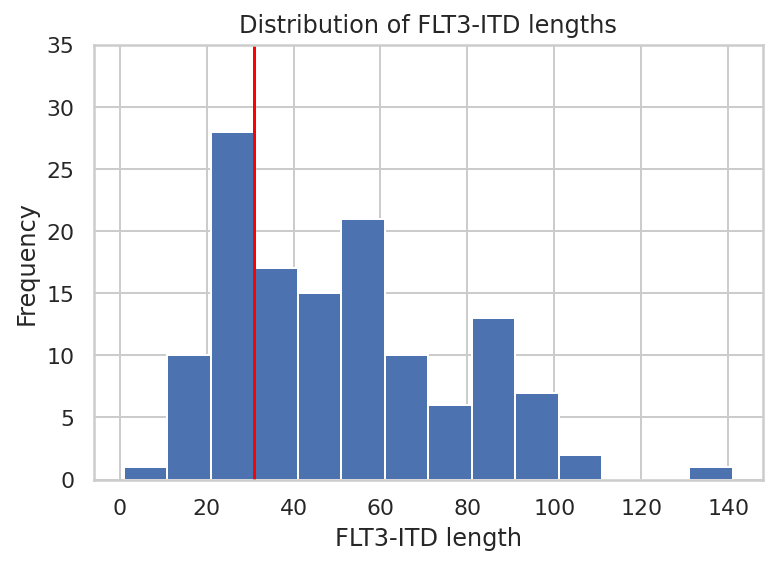

In [ ]:
# plot ITD lengths
with open('data/itd_table', 'rb') as f:
    itd_data = pickle.load(f)
itd_lengths = [j[2] for j in [i for i in list(itd_data.values()) if i != '']]
sns.set_style("whitegrid")
plt.hist(itd_lengths, bins=[1+i*10for i in range(15)])
plt.vlines(31, 0, 35, color='red')
plt.ylim(0,35)
plt.ylabel("Frequency")
plt.xlabel("FLT3-ITD length")
plt.title("Distribution of FLT3-ITD lengths")
plt.show()

### PyTorch Model

In [ ]:
from pyt_model import *

input_size = km_normed_1.shape[1]
model = define_model(input_size)
t_losses, v_losses = train_model(model, 2000, [train_loader, valid_loader, test_loader], 'flt3')
eval_model('flt3', 'final', test_loader, input_size)
eval_model('flt3', 'best', test_loader, input_size)

# Validation graph
plt.plot(t_losses)
plt.plot(v_losses)
plt.ylim(0,1)
plt.show()